# Binary Classification with Gaussian Processes


Let's get started!

First let's download our packages to build our image library

In [1]:
import os
import numpy as np
import pandas as pd

from skimage import io

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

Next lets read in our images to a numpy array for building 

In [2]:
train_path = "class_dataset/train"
test_path = "class_dataset/test"

def load_images_from_folder(folder_path):
    """Load images from a folder and convert to grayscale."""
    images = []
    labels = []
    image_paths = []
    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = io.imread(img_path)
                images.append(img)
                labels.append(class_name)
                image_paths.append(img_path)

    return np.array(images), np.array(labels), image_paths

train_images, train_labels = load_images_from_folder(train_path)[:2]
test_images, test_labels, test_image_paths = load_images_from_folder(test_path)

Let's look at a few of our images

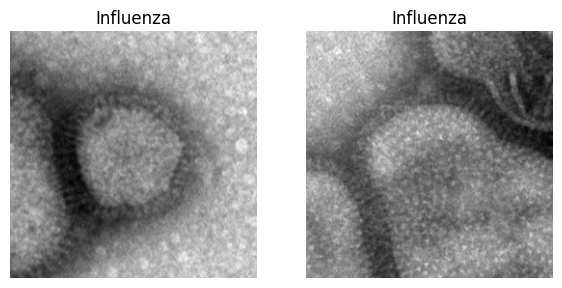

In [7]:
random_idx = np.random.randint(3, train_images.shape[0], size=2)

image_one = train_images[random_idx[0]]
label_one = train_labels[random_idx[0]]

image_two = train_images[random_idx[1]]
label_two = train_labels[random_idx[1]]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 4))

ax[0].imshow(image_one, cmap='gray')
ax[0].set_title(label_one)
ax[0].axis('off')

ax[1].imshow(image_two, cmap='gray')
ax[1].set_title(label_two)
ax[1].axis('off')
plt.subplots_adjust()
plt.show()

Let's generate our features

In [8]:

from skimage.feature import graycomatrix, graycoprops
from skimage import feature, exposure

def extract_features(images):

    features_list = []
    
    for image in images:

        # further increase contrast
        image = exposure.equalize_adapthist(image)

        image = (image * 255).astype(np.uint8)
        
        # Mean and Variance
        mean_val = np.mean(image)
        var_val = np.var(image)
        
        # GLCM features
        glcm = graycomatrix(image, 
                           distances=[1], 
                           angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                           levels=256,
                           symmetric=True,
                           normed=True)
        
        contrast = np.mean(graycoprops(glcm, 'contrast'))
        correlation = np.mean(graycoprops(glcm, 'correlation'))
        energy = np.mean(graycoprops(glcm, 'energy'))
        homogeneity = np.mean(graycoprops(glcm, 'homogeneity'))
        dissimilarity = np.mean(graycoprops(glcm, 'dissimilarity'))
        asm = np.mean(graycoprops(glcm, 'ASM'))
        
        
        # LBP features
        lbp = feature.local_binary_pattern(image, P=8, R=1, method='uniform')
        lbp_hist, _ = np.histogram(lbp, bins=10, density=True)
        
        # Combine all features
        features = [mean_val, var_val, contrast, correlation, energy, homogeneity, dissimilarity, asm]
        features.extend(lbp_hist)
        features_list.append(features)
    
    return np.array(features_list)

# Extract features
train_features = extract_features(train_images)
test_features = extract_features(test_images)



Now let's assemble our dataframe

In [9]:
# Create feature names
feature_names = ['mean', 'variance', 'contrast', 'correlation', 'energy', 'homogeneity', 'dissimilarity', 'asm']
feature_names.extend([f'lbp_{i}' for i in range(10)])


train_df = pd.DataFrame(train_features, columns=feature_names)
train_df['label'] = train_labels

test_df = pd.DataFrame(test_features, columns=feature_names)
test_df['label'] = test_labels


In [10]:
train_df.head()

,mean,variance,contrast,correlation,energy,homogeneity,dissimilarity,asm,lbp_0,lbp_1,lbp_2,lbp_3,lbp_4,lbp_5,lbp_6,lbp_7,lbp_8,lbp_9,label
0,124.407990,1859.644305,375.444345,0.898721,0.010475,0.066158,15.291914,0.000110,0.108948,0.109541,0.086636,0.097266,0.095842,0.092010,0.087568,0.108049,0.121935,0.203315,Adenovirus
1,116.300873,1718.092367,379.537722,0.888935,0.010680,0.065926,15.369456,0.000114,0.114288,0.112118,0.084890,0.090061,0.091078,0.089162,0.086195,0.105913,0.126953,0.210453,Adenovirus
2,107.384430,1654.481242,413.262866,0.874916,0.010831,0.065846,16.094543,0.000118,0.111220,0.110864,0.087043,0.088450,0.085636,0.091315,0.088111,0.108524,0.127936,0.212012,Adenovirus
3,120.311813,1992.452959,247.521444,0.937577,0.011491,0.083574,12.207635,0.000132,0.076853,0.090366,0.097385,0.137736,0.137380,0.129378,0.103149,0.091722,0.090400,0.156742,Adenovirus
4,97.348785,2476.258140,103.149355,0.979095,0.014115,0.125803,7.902611,0.000200,0.095164,0.098385,0.082991,0.105964,0.117137,0.107456,0.092587,0.103472,0.120154,0.187802,Adenovirus


Let's normalize and standardize our data to ensure equal feature imporance, numerical stability, and improved performance.

Important to use the same scaler and standardizer out for using to classify new images in the future.

In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X = train_df.drop('label', axis=1)
y = train_df['label']

scaler = MinMaxScaler()
scaler.fit(X)
X_norm = scaler.transform(X)

standardizer = StandardScaler()
standardizer.fit(X_norm)
X_norm_std = standardizer.transform(X_norm)

Now the fun begins!  Next let's review model performance with k-fold Stratified Cross Validation

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score

# 5-fold cross-validation on our training data
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42,)

# For storing ROC curve data
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

# For storing fold metrics
fold_metrics = []

# Perform k-fold cross-validation
print("\nPerforming 5-fold cross-validation...")
for fold, (train_idx, test_idx) in enumerate(skf.split(X_norm_std, y)):
    print(f"\nTraining fold {fold+1}/{n_folds}")
    
    # Split data for this fold
    X_train_fold = X_norm_std[train_idx]
    y_train_fold = y.iloc[train_idx]
    X_test_fold = X_norm_std[test_idx]
    y_test_fold = y.iloc[test_idx]
    
    # Initialize and train Gaussian Process Classifier
    kernel = 1.0 * RBF(length_scale=[1 for x in range(len(X.columns))])
    gpc = GaussianProcessClassifier(kernel=kernel, 
                                    random_state=42,
                                    n_jobs=-1)
    gpc.fit(X_train_fold, y_train_fold)
    
    # Make predictions
    y_pred_fold = gpc.predict(X_test_fold)
    y_pred_proba_fold = gpc.predict_proba(X_test_fold)[:, 1]  # Get probability of positive class
    
    # Print classification report for this fold
    fold_report = classification_report(y_test_fold, y_pred_fold, output_dict=True)
    print(f"Fold {fold+1} Classification Report:")
    print(classification_report(y_test_fold, y_pred_fold))
    
    # Convert string labels to binary for ROC curve calculation
    # Determine the positive class (needed for ROC curve)
    pos_class = gpc.classes_[1]  # Second class is the positive class
    
    # Convert labels to binary (1 for positive class, 0 for negative class)
    y_test_binary = (y_test_fold == pos_class).astype(int)
    
    # Compute ROC curve and ROC area for this fold
    fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba_fold)
    roc_auc = auc(fpr, tpr)
    
    print(f"Positive class: {pos_class}, AUC: {roc_auc:.4f}")
    

Now lets train the final model with all the training data and validate on the test data

In [35]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score


kernel = 1.0 * RBF(length_scale=[1 for x in range(len(X.columns))])
gpc = GaussianProcessClassifier(kernel=kernel, 
                                random_state=42,
                                n_jobs=-1)
gpc.fit(X_norm_std, y)

# Make predictions on test data
print("Making predictions on test data...")
X_test_norm = scaler.transform(test_df.drop('label', axis=1))
X_test_norm_std = standardizer.transform(X_test_norm)
test_pred = gpc.predict(X_test_norm_std)

# Print test classification report
print("\nFinal Test Results:")
print(classification_report(test_df['label'], test_pred))

c:\Users\mattl\AppData\Local\Programs\Python\Python311\pytorch\Lib\site-packages\sklearn\gaussian_process\_gpc.py:477: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Making predictions on test data...

Final Test Results:
              precision    recall  f1-score   support

  Adenovirus       1.00      1.00      1.00        86
   Influenza       1.00      1.00      1.00       170

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256



With Gaussian Process How can we assess our Feature Importance?  With Shapley values!


Calculating SHAP values...


  0%|          | 0/50 [00:00<?, ?it/s]

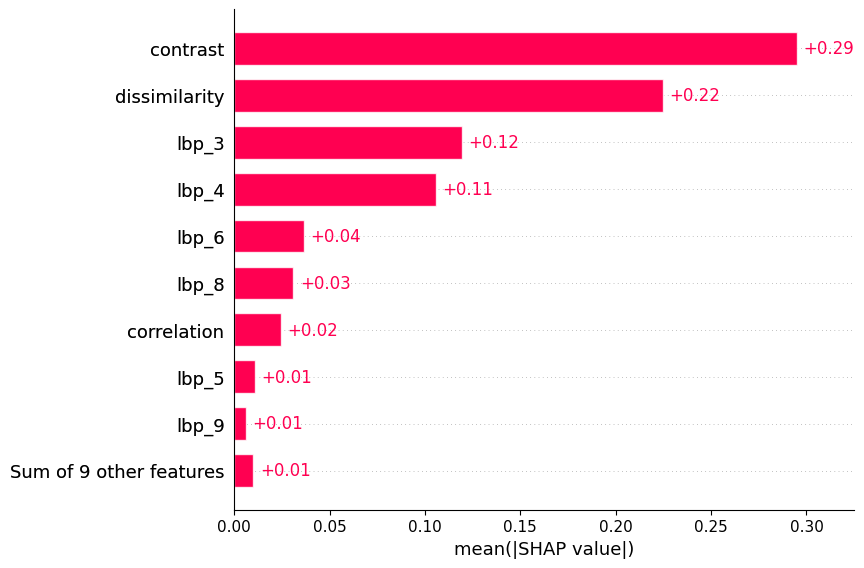

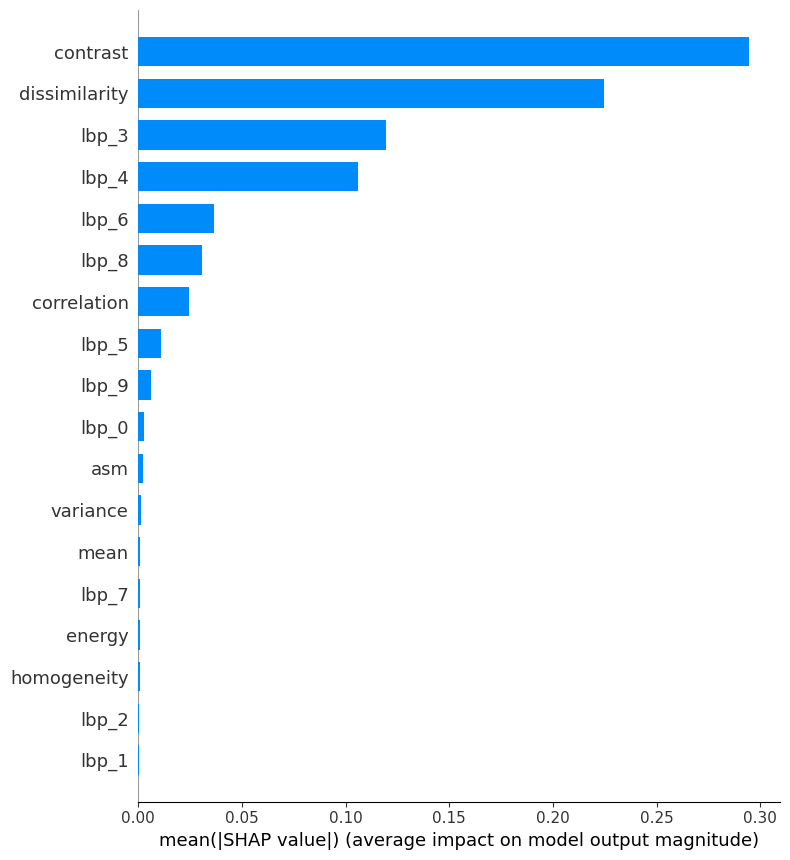

In [42]:
import shap

# Calculate SHAP values
print("\nCalculating SHAP values...")
sample_size = min(50, len(X_test_norm_std))

# Create a SHAP explainer
explainer = shap.KernelExplainer(gpc.predict_proba, X_norm_std[:100],feature_names=feature_names)
shap_values = explainer(X_test_norm_std[:sample_size])

# Get feature names
feature_names = ['mean', 'variance', 'contrast', 'correlation', 'energy', 'homogeneity', 'dissimilarity', 'asm']
feature_names.extend([f'lbp_{i}' for i in range(10)])

# Global SHAP values
shap_values = shap_values[..., 1]
shap.plots.bar(shap_values)

#Bar chart of mean importance
shap.summary_plot(shap_values, X_norm_std, plot_type="bar")
    

Now lets take a sample of our test set and see how well it classifies

c:\Users\mattl\AppData\Local\Programs\Python\Python311\pytorch\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\mattl\AppData\Local\Programs\Python\Python311\pytorch\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\mattl\AppData\Local\Programs\Python\Python311\pytorch\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


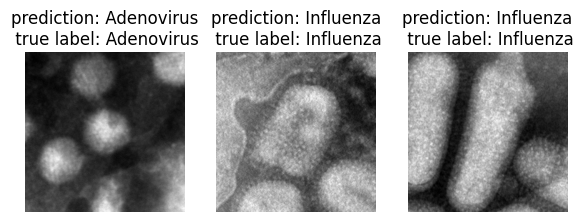

In [52]:
import random

# Take random sample of 3 images and corresponding labels
num_samples=3
test_data = list(zip(test_images, test_labels))
random_samples = random.sample(test_data, min(num_samples, len(test_data)))

# extract features from images
sample_images=[]
sample_labels=[]
for i in range(num_samples):
    sample_img = random_samples[i][0]
    sample_images.append(sample_img)

    sample_label = random_samples[i][1] 
    sample_labels.append(sample_label)
    
# extract features from array of images
sample_features = extract_features(np.array(sample_images))
sample_df = pd.DataFrame(sample_features, columns=feature_names)

pred_labels = []
for _, row in sample_df.iterrows():

    # Scale features
    features_scaled = scaler.transform(row[feature_names].values.reshape(1, -1))
    features_scaled_std = standardizer.transform(features_scaled)

    pred_class = gpc.predict(features_scaled_std)[0]
    pred_labels.append(pred_class)




fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(7, 6))

ax[0].imshow(random_samples[0][0], cmap='gray')
ax[0].set_title(f"prediction: {pred_labels[0]}\n true label: {random_samples[0][1]}")
ax[0].axis('off')

ax[1].imshow(random_samples[1][0], cmap='gray')
ax[1].set_title(f"prediction: {pred_labels[1]}\n true label: {random_samples[1][1]}")
ax[1].axis('off')

ax[2].imshow(random_samples[2][0], cmap='gray')
ax[2].set_title(f"prediction: {pred_labels[2]}\n true label: {random_samples[2][1]}")
ax[2].axis('off')

plt.subplots_adjust()
plt.show()



